### module

In [1]:
%%writefile tight_binding.py
# -*- coding: utf-8 -*-
from __future__ import print_function, division, absolute_import, unicode_literals

import numpy as np
from itertools import product 

class Tight_binding():
    
    def read_file(self, name):
        ''' Readind file with structure '''
        with open(name) as f:
            data = [i for i in f.read().split('\n') if i != '']

        self.vectors = np.array([eval(i) for i in data[0].replace(' ', '').replace(')(', ') (').split(' ') ], dtype=np.float64)
        self.N = np.int32(data[1])
        self.coordinates = np.array([eval(i) for i in data[2].replace(' ', '').replace(')(', ') (').split(' ') ], dtype=np.float64)

        self.R = []
        self.T = {}
        for k in data[3:]:
            parts = k.split(')')
            r = eval(parts[0] + ')')
            i,j,t = map(float, parts[1].split())
            i, j = np.int(i), np.int(j)

            if r not in self.T.keys():
                self.R = np.append(self.R, r)
                self.T[r] = np.zeros((self.N,self.N), dtype = np.float64)
            self.T[r][i,j] += t
        self.R = self.R.reshape((-1, 3))

        index = list(range(3))
        for i in index:
            if all(self.vectors[i] == np.zeros(3)): 
                ind = index.pop(i)
        self.k_vec = np.zeros((3,3), dtype = np.float64)
        vs = np.zeros((3,3), dtype = np.float64)
        vs[index] = self.vectors[index]
        if len(index) == 1:
            V = np.linalg.norm(vs[index])
            self.k_vec = vs / V**2
        elif len(index) == 2:
            V = np.linalg.norm(np.cross(vs[index[0]], vs[index[1]]))
            n = np.cross(vs[index[0]], vs[index[1]]) / V
            if ind == 1:
                n *= -1
            vs[ind] = n
            for i, j in enumerate([[1,2], [2,0], [0, 1]]):
                 self.k_vec[i] = np.cross(vs[j[0]],vs[j[1]]) / V
            self.k_vec[ind] = 0.
        else:
            V = np.dot(vs[0], np.cross(vs[1], vs[2]))
            for i, j in enumerate([[1,2], [2,0], [0, 1]]):
                 self.k_vec[i] = np.cross(vs[j[0]],vs[j[1]]) / V

    def make_k_points(self, points):
        points = np.array(points)
        assert all(points)
        self.nkx, self.nky, self.nkz = points
        
        self.k_points = []
        for n in product(range(1, self.nkx + 1),range(1, self.nky + 1),range(1, self.nkz + 1)):
            self.k_points.append(np.sum((2. * np.array(n) - points - 1) * self.k_vec / 2. / points , axis = 0))
        self.k_points = np.array(self.k_points)
    
    def get_kpts(self):
        return self.k_points
        
    def dop(self, kpt):
        ''' Calculate energy for a single k-point '''
        H = np.zeros((self.N, self.N) , dtype = np.complex128)
        for r in self.R:
            for i in range(self.N):
                for j in range(self.N):
                    H[i,j] += self.T[tuple(r)][i,j] * np.exp(2. * np.pi * 1j * np.dot(kpt , self.coordinates[i] - self.coordinates[j] + r))
        return np.linalg.eig(H)[0]
    
    def dispersion(self):
        '''
        Calculate system dispersion
                
        ####----------####
        If k_point was not calculate before, it compute with k_point grid (20, 20, 20)
        
        '''
        
        try:
            size = self.get_kpts().shape[0]
        except :
            self.make_k_points((20, 20, 20))
            size = self.get_kpts().shape[0]
        
        self.E = np.zeros((self.N, self.get_kpts().shape[0]), dtype=np.complex128)
        for k in range(self.get_kpts().shape[0]):
            self.E[:,k] = self.dop(self.k_points[k])

            
        return self.E
    
    def gf_iwn(self, wn, mu, sigma = 0):
        '''Return Green function in matsubara frequencies'''
        self.g_wn = np.zeros(len(wn), dtype=np.complex128)
        if isinstance(sigma, int): sigma = np.zeros(len(wn), dtype=np.complex128)
        for w in range(len(wn)):
            for i in range(self.N):
                self.g_wn[w] += np.sum(1. / (1j*wn[w] - self.E[i] + mu - sigma[w])) 
        self.g_wn /= self.N * self.k_points.shape[0]
        return self.g_wn
    
    def gf_w(self, omega, mu, etta = 0, sigma = 0):
        '''Return Green function in real frequencies'''
        try:
            tmp = self.E[0]
        except:
            self.dispersion()
        
        self.gw = np.zeros(omega.shape[0], dtype=np.complex128)
        if sigma == 0: sigma = np.zeros(omega.shape[0], dtype=np.complex128)
        for w in range(omega.shape[0]):
            for i in range(self.N):
                self.gw[w] += np.sum(1. / (omega[w] + 1j * etta - self.E[i] + mu - sigma[w])) 
        self.gw /= self.N * self.k_points.shape[0] 
        return self.gw
    
    def DOS(self, w, mu, etta, sigma = 0):
        self.omega = w 
        self.dos = -np.imag(self.gf_w(w, mu, etta, sigma)) / np.pi
        
    def HT(self, g, wn, mu = 0, sigma = 0):
        if isinstance(sigma, int): sigma = np.zeros(g.shape[0], dtype=np.complex128)
        dw = (self.omega[-1] - self.omega[0]) / self.omega.shape[0]
        for i in range(g.shape[0]):
            g[i] = np.sum(self.dos * dw / (1j * wn[i] - self.omega - sigma[i] + mu))

Overwriting tight_binding.py


In [25]:
a = Dispersion()

In [26]:
a.read_file('test_data/cubic.txt')

In [27]:
a.make_k_points((50,50,50))

In [28]:
e = a.dispersion()

In [29]:
w = np.linspace(-8,8, 1000)
d = DOS(a,w,etta = 0.1)

In [30]:
d.gf_imp(mu=0.0)

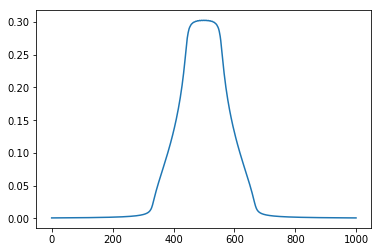

In [31]:
plt.plot(d.dos())

In [ ]:
beta = 10.
num_iw = 128
wn = np.pi * (2 * np.array(range(-int(num_iw / 2), num_iw / 2)) + 1) / beta

In [ ]:
a.gf_imp(wn, mu = 0.0)

In [ ]:
plt.plot(a.g0.imag)

In [188]:
from pytriqs.lattice.tight_binding import *
from pytriqs.gf import *
from pytriqs.dos import HilbertTransform

BL = BravaisLattice(units = [(1,0,0) , (0,1,0) ,(0,0,1)])

t1  = -0.45                # First neighbour Hopping
t2  = -0.00                # Second neighbour Hopping
t4  =  0.00                # Fourth neighbour Hopping

hop={}

hop[(1,0,0)]=[[t1]]
hop[(0,1,0)]=[[t1]]
hop[(0,0,1)]=[[t1]]
hop[(-1,0,0)]=[[t1]]
hop[(0,-1,0)]=[[t1]]
hop[(0,0,-1)]=[[t1]]


TB = TightBinding ( BL, hop)
d = dos (TB, n_kpts= 500, n_eps = 101, name = 'dos')[0]

Starting on 1 Nodes at : 2020-01-20 16:42:09.254740


In [189]:
mu = 0.0

In [191]:
H = HilbertTransform(d)
G = GfImFreq(mesh = MeshImFreq(beta, 'Fermion', num_iw//2), indices = [1])
Sigma0 = GfImFreq(mesh = MeshImFreq(beta, 'Fermion', num_iw//2), indices = [1])
Sigma0.zero()
G << H(Sigma = Sigma0, mu=mu)
gf_initial = G.data[:,0,0].astype(np.complex128)

/home/aegaeon/anaconda3/envs/aegaeon/lib/python2.7/site-packages/pytriqs/gf/gf.py:655: UserWarning: g.N1 is deprecated and not generic. Use g.target_shape[0] instead
  warnings.warn("g.N1 is deprecated and not generic. Use g.target_shape[0] instead")
/home/aegaeon/anaconda3/envs/aegaeon/lib/python2.7/site-packages/pytriqs/gf/gf.py:661: UserWarning: g.N2 is deprecated and not generic. Use g.target_shape[1] instead
  warnings.warn("g.N2 is deprecated and not generic. Use g.target_shape[1] instead")


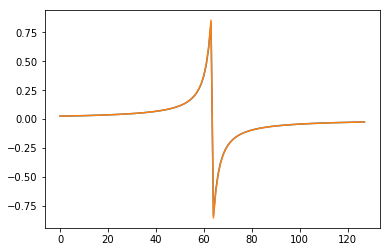

In [192]:
plt.plot(g.imag)
plt.plot(gf_initial.imag)

In [361]:
Sigma0.data[:,0,0] = np.random.sample(num_iw) + 1j * np.random.sample(num_iw) 

In [362]:
G << H(Sigma = Sigma0, mu=mu)
gf = G.data[:,0,0].astype(np.complex128)

In [363]:
g = np.zeros(num_iw, dtype=np.complex128)
sigma = Sigma0.data[:,0,0]
d.HT(g, wn, sigma)

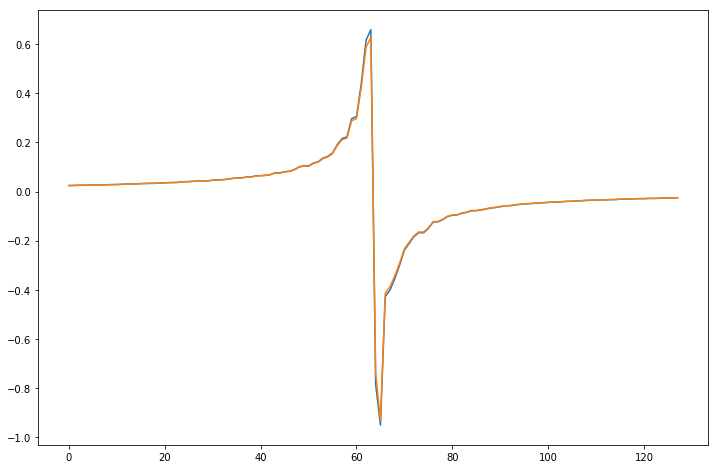

In [364]:
plt.figure(figsize=(12,8))
plt.plot(gf.imag)
plt.plot(g.imag)